# Intialize

In [20]:
from pycaret.regression import *

# ===============****===================
"""
Annual Water Use Model
Date: 7/14/2022
"""
# ===============****===================
import os
import warnings
import pandas as pd
#from iwateruse import data_cleaning, report, splittors, pre_train_utils, make_dataset, figures
from iwateruse import denoise, model_diagnose
import matplotlib.pyplot as plt
import xgboost as xgb
import json
import shap
import joblib
from sklearn.pipeline import Pipeline
from iwateruse.model import Model
from iwateruse import targets, weights, pipelines, outliers_utils, estimators, featurize, predictions
from iwateruse import selection
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')
xgb.set_config(verbosity=0)

# =============================
# Flags
# =============================
apply_summary_encoding = False
apply_onehot_encoding = True
train_initial_model = True
plot_diagnosis = False
run_boruta = True
use_boruta_results = False
run_permutation_selection = False
run_chi_selection = False
run_RFECV_selection = False
detect_outliers = False
use_denoised_data = True

interpret_model = False
quantile_regression = False

# files
usa_conus_file = r"C:\work\water_use\mldataset\gis\nation_gis_files\conus_usa2.shp"
huc2_shp_file = r'C:\work\water_use\mldataset\gis\nation_gis_files\conus_huc2.shp'
state_shp_file = r'C:\work\water_use\mldataset\gis\nation_gis_files\conus_states.shp'
county_shp_file = r'C:\work\water_use\mldataset\gis\nation_gis_files\conus_county.shp'
prediction_file = os.path.abspath(r"..\..\..\mldataset\ml\training\train_datasets\Annual\wu_annual_training3.csv")

# =============================
# Setup Training
# =============================
figures_folder = "figs"
model = Model(name='annual_pc', log_file='train_log.log', feature_status_file=r"..\features_status.xlsx")
model.raw_target = 'wu_rate'
model.target = 'per_capita'

datafile = r"..\clean_train_db.csv"
df_train = pd.read_csv(datafile)
del (df_train['dom_frac'])
del (df_train['cii_frac'])
model.add_training_df(df_train=df_train)

# make_dataset.make_ds_per_capita_basic(model, datafile=datafile)
# model.df_train['pop_density']  = model.df_train['pop']/model.df_train['WSA_SQKM']
# model.df_train.loc[model.df_train['WSA_SQKM']==0, 'pop_density'] = np.NaN
# add water use
seed1 = 123
seed2 = 456

model.apply_func(func=targets.compute_per_capita, type='target_func', args=None)

opts = ['pop<=100', 'per_capita>=500', 'per_capita<=25']
model.apply_func(func=outliers_utils.drop_values, type='outliers_func', opts=opts)
model.apply_func(func=outliers_utils.drop_na_target, type='outliers_func')

# =============================
# Feature Engineering
# =============================
# Target summary
if apply_summary_encoding:
    df_trans, encoding_summary = featurize.summary_encode(model, cols=model.categorical_features)
    fn = "..\summary_encoding.json"
    model.dict_to_file(data = encoding_summary, fn=fn)
    model.add_feature_to_skip_list(model.categorical_features)
    model.add_training_df(df_train=df_trans)


# =============================
# Prepare the initial estimator
# =============================
params = {
    'objective': "reg:squarederror",
    'tree_method': 'hist',
    'colsample_bytree': 0.5972129389586888,
    'learning_rate': 0.04371772054983907,
    'max_depth': 11,
    'alpha': 100,
    'n_estimators': 300,
    'subsample': 1,
    'reg_lambda': 1.2998981941716606e-08,
    'min_child_weight': 4,
    'gamma': 10,
    'max_delta_step': 0,
    'seed': seed2,
    'importance_type': 'total_gain'
}

gb = estimators.xgb_estimator(params)
if apply_onehot_encoding:
    # pipeline
    main_pipeline = pipelines.make_pipeline(model)
    main_pipeline.append(('estimator', gb))
    gb = Pipeline(main_pipeline)
    
    preprocess = main_pipeline[0][1]

features = model.features
target = model.target

final_dataset = model.df_train
model.log.to_table(final_dataset[features].describe(percentiles=[0, 0.05, 0.5, 0.95, 1]), "Features", header=-1)
model.log.to_table(final_dataset[[target]].describe(percentiles=[0, 0.05, 0.5, 0.95, 1]), "Target", header=-1)



# =============================
# Prepare the initial estimator
# =============================

# select features

def load_features_selected(method = 'xgb_cover'):
    feat_selec_file = '..\confirmed_selected_features.json'
    f = open(feat_selec_file)
    feature_selection_info = json.load(f)
    f.close()
    features_selected = feature_selection_info[method]
    return features_selected

feature_selected = load_features_selected()
target = model.target
final_dataset = model.df_train
ignore_features = list(set(final_dataset.columns).difference(set(feature_selected + [target])))
categorical_features = model.categorical_features



# Pycaret Setup

In [21]:
# =============================
# Prepare the initial estimator
# =============================
reg1 = setup(data = final_dataset, target = target, ignore_features = ignore_features,
             fold=5, fold_shuffle = True, categorical_features = categorical_features,
             preprocess = preprocess,
             train_size = 0.7)

# compare models
#learning_algorithems = ['xgboost', 'rf', 'lightgbm', 'et'] # include = learning_algorithems
#best = compare_models(n_select = 5)





,Description,Value
0,session_id,2372
1,Target,per_capita
2,Original Data,"(80806, 124)"
3,Missing Values,True
4,Numeric Features,60
5,Categorical Features,7
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(56564, 2754)"


# Tune Xgboost

In [ ]:
xgb = create_model('xgboost')
tuned_xgb= tune_model(xgb, fold = 5, search_library = 'scikit-optimize',
                      search_algorithm = 'bayesian', n_iter = 200)
df_xgb = pd.DataFrame.from_dict(tuned_xgb.get_params(), orient = 'index')
df_xgb.to_csv("annual_xgb_tune.csv")

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,44.0461,3805.5610,61.6892,0.5530,0.3989,0.3614
1,44.4166,3838.9912,61.9596,0.5537,0.4026,0.3677
2,44.5078,3878.5400,62.2779,0.5398,0.4037,0.3651
3,43.3385,3675.6858,60.6274,0.5553,0.4012,0.3658
4,44.3470,3771.0920,61.4092,0.5370,0.4056,0.3729
Mean,44.1312,3793.9740,61.5927,0.5478,0.4024,0.3666
Std,0.4255,69.0332,0.5619,0.0077,0.0023,0.0037


IntProgress(value=0, description='Processing: ', max=7)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,11:32:39
Status,. . . . . . . . . . . . . . . . . .,Searching Hyperparameters
Estimator,. . . . . . . . . . . . . . . . . .,Extreme Gradient Boosting


,Fold,MAE,MSE,RMSE,R2,RMSLE,MAPE


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 18.5min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 13.9min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [22]:
params = {
    'objective': "reg:squarederror",
    'tree_method': 'hist',
    'colsample_bytree': 0.8,
    'learning_rate': 0.20,
    'max_depth': 7,
    'alpha': 100,
    'n_estimators': 500,
    'rate_drop': 0.9,
    'skip_drop': 0.5,
    'subsample': 0.8,
    'reg_lambda': 10,
    'min_child_weight': 50,
    'gamma': 10,
    'max_delta_step': 0,
    'seed': 123
}
params_tuned = {'objective': 'reg:squarederror',
 'base_score': 0.5,
 'booster': 'gbtree',
 'callbacks': None,
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 0.5,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'gamma': 10,
 'gpu_id': -1,
 'grow_policy': 'depthwise',
 'importance_type': None,
 'interaction_constraints': '',
 'learning_rate': 0.06740244695074946,
 'max_bin': 256,
 'max_cat_to_onehot': 4,
 'max_delta_step': 0,
 'max_depth': 11,
 'max_leaves': 0,
 'min_child_weight': 1,
 'monotone_constraints': '()',
 'n_estimators': 300,
 'n_jobs': -1,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 2783,
 'reg_alpha': 1e-10,
 'reg_lambda': 1e-10,
 'sampling_method': 'uniform',
 'scale_pos_weight': 50.0,
 'subsample': 1.0,
 'tree_method': 'hist',
 'validate_parameters': 1,
 'verbosity': 0,
 'alpha': 100,
 'rate_drop': 0.9,
 'skip_drop': 0.5,
 'seed': 123}
xgb = create_model('xgboost', **params_tuned)


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,32.8767,2415.8130,49.1509,0.7162,0.3186,0.2669
1,32.7703,2347.9048,48.4552,0.7270,0.3195,0.2696
2,33.3166,2541.7356,50.4156,0.6984,0.3259,0.2717
3,32.2634,2349.3674,48.4703,0.7158,0.3255,0.2728
4,32.4870,2337.2515,48.3451,0.7131,0.3214,0.2716
Mean,32.7428,2398.4145,48.9674,0.7141,0.3222,0.2705
Std,0.3586,76.8653,0.7782,0.0092,0.0030,0.0021


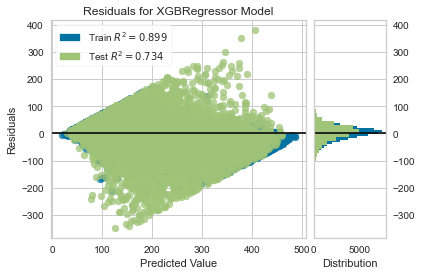

In [23]:
plot_model(xgb)

In [ ]:
tuned_xgb= tune_model(xgb, fold = 5, search_library = 'scikit-optimize',
                      search_algorithm = 'bayesian', n_iter = 100)

In [ ]:
df_xgb = pd.DataFrame.from_dict(tuned_xgb.get_params(), orient = 'index')
df_xgb.to_csv("annual_xgb_tune.csv")
df_xgb

In [ ]:
tuned_xgb.get_params()
"""
{'objective': 'reg:squarederror',
 'base_score': 0.5,
 'booster': 'gbtree',
 'callbacks': None,
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 0.5,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'gamma': 10,
 'gpu_id': -1,
 'grow_policy': 'depthwise',
 'importance_type': None,
 'interaction_constraints': '',
 'learning_rate': 0.06740244695074946,
 'max_bin': 256,
 'max_cat_to_onehot': 4,
 'max_delta_step': 0,
 'max_depth': 11,
 'max_leaves': 0,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 300,
 'n_jobs': -1,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 2783,
 'reg_alpha': 1e-10,
 'reg_lambda': 1e-10,
 'sampling_method': 'uniform',
 'scale_pos_weight': 50.0,
 'subsample': 1.0,
 'tree_method': 'hist',
 'validate_parameters': 1,
 'verbosity': 0,
 'alpha': 100,
 'rate_drop': 0.9,
 'skip_drop': 0.5,
 'seed': 123}
"""

In [ ]:
plot_model(tuned_xgb,  plot = 'error')

In [ ]:
interpret_model(tuned_xgb, plot = 'correlation', feature = 'pop_density', cmap = None)

In [ ]:
interpret_model(tuned_xgb, plot = 'correlation', feature = 'median_income', cmap = None)

In [ ]:
interpret_model(tuned_xgb, plot = 'correlation', feature = 'pop', cmap = None)

In [ ]:
interpret_model(tuned_xgb, plot = 'correlation', feature = 'YearBuilt_mean', cmap = None)

In [ ]:
interpret_model(tuned_xgb, plot = 'correlation', feature = 'Year', cmap = None)

In [ ]:
interpret_model(tuned_xgb, plot = 'correlation', feature = 'LONG', cmap = None)

In [ ]:
interpret_model(tuned_xgb, plot = 'correlation', feature = 'LAT', cmap = None)

In [ ]:
interpret_model(tuned_xgb, plot = 'correlation', feature = 'pov_2019', cmap = None)

# Light GBM

In [ ]:
lgb = create_model('lightgbm')
tuned_lgb= tune_model(lgb, fold = 3, search_library = 'scikit-optimize',
                      search_algorithm = 'bayesian', n_iter = 100)# fit_params = {'objective': 'quantile', 'alpha':0.5}

In [ ]:
df_lgb = pd.DataFrame.from_dict(tuned_lgb.get_params(), orient = 'index')
df_lgb.to_csv("lgb_tune.csv")
df_lgb

In [ ]:
# tune et
et = create_model('et')
tuned_lgb= tune_model(et, fold = 3, search_library = 'scikit-optimize',
                      search_algorithm = 'bayesian', n_iter = 100)